## LUNGXAI Pipeline 
implements a complete deep learning workflow: preprocessing gene expression data with PCA, then training and evaluating a 1D CNN for multi-class classification using PyTorch.


🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0106 Train Accuracy: 68.20% | Test Loss: 0.0084 Test Accuracy: 88.50%
Epoch [2/50] Train Loss: 0.0069 Train Accuracy: 82.37% | Test Loss: 0.0055 Test Accuracy: 92.68%
Epoch [3/50] Train Loss: 0.0047 Train Accuracy: 90.99% | Test Loss: 0.0040 Test Accuracy: 93.82%
Epoch [4/50] Train Loss: 0.0037 Train Accuracy: 93.11% | Test Loss: 0.0033 Test Accuracy: 94.77%
Epoch [5/50] Train Loss: 0.0030 Train Accuracy: 94.44% | Test Loss: 0.0030 Test Accuracy: 95.06%
Epoch [6/50] Train Loss: 0.0027 Train Accuracy: 94.80% | Test Loss: 0.0026 Test Accuracy: 95.06%
Epoch [7/50] Train Loss: 0.0026 Train Accuracy: 95.15% | Test Loss: 0.0025 Test Accuracy: 95.25%
Epoch [8/50] Train Loss: 0.0023 Train Accuracy: 95.51% | Test Loss: 0.0024 Test Accuracy: 95.63%
Epoch [9/50] Train Loss: 0.0022 Train Accuracy: 95.72% | Test Loss: 0.0023 Test Accuracy: 95.44%
Epoch [10/50] Train Loss: 0.0019 Train Accuracy: 96.39% | Test Loss: 0.0021 Test Accuracy: 95.72%
Epoch [1

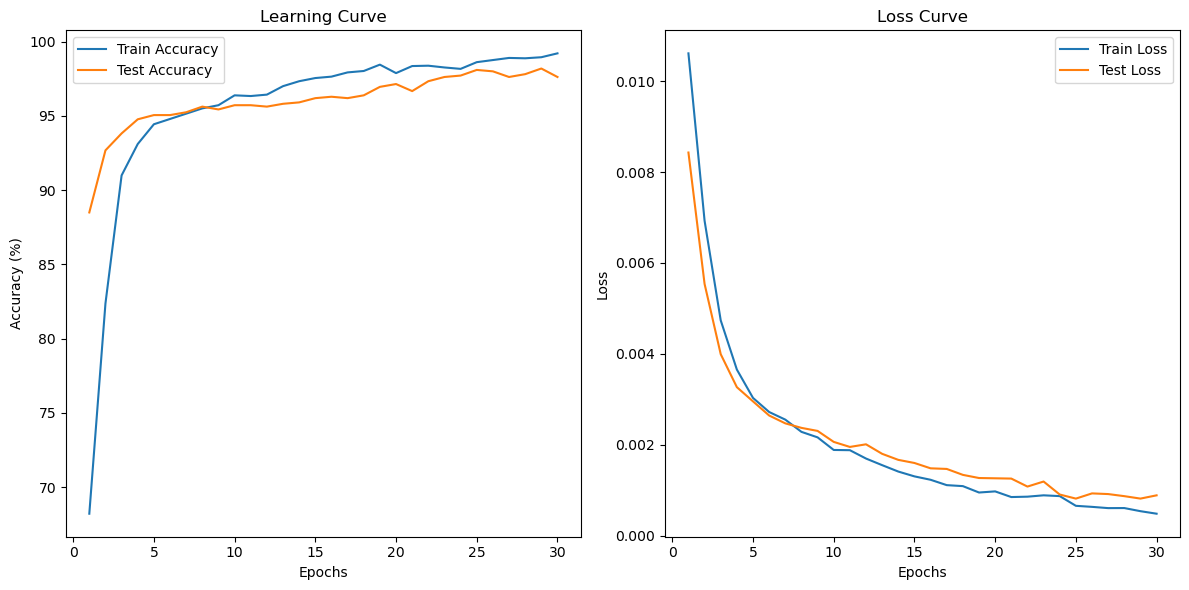

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Simple CNN Model ---
class CNN_Model(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters=64):
        super(CNN_Model, self).__init__()
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Fully connected layer for classification
        self.fc1 = nn.Linear(cnn_filters*2 * (input_dim // 2), 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        # Add channel dimension (batch_size, 1, features)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        
        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# --- Initialize Model ---
input_dim = X_train.size(1)  # Number of features after PCA
num_classes = len(label_encoder.classes_)

model = CNN_Model(input_dim=input_dim, num_classes=num_classes).to(device)

# --- Loss and Optimisers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Training the Model ---
num_epochs = 50
batch_size = 64
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]
            
            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    train_accuracies.append(epoch_accuracy)
    test_accuracies.append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Plotting Learning Curves and Loss Curves ---
# Learning curve (Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()


## LUNGXAI: Final Pipeline with Reproducibility  
This builds and trains a 1D CNN model for gene expression classification, including preprocessing with PCA, model initialisation, training with early stopping, saving results, and visualising performance—all with reproducible results.


🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0119 Train Accuracy: 62.48% | Test Loss: 0.0100 Test Accuracy: 71.48%
Epoch [2/50] Train Loss: 0.0090 Train Accuracy: 73.48% | Test Loss: 0.0080 Test Accuracy: 89.83%
Epoch [3/50] Train Loss: 0.0072 Train Accuracy: 82.77% | Test Loss: 0.0061 Test Accuracy: 92.78%
Epoch [4/50] Train Loss: 0.0055 Train Accuracy: 88.88% | Test Loss: 0.0046 Test Accuracy: 93.35%
Epoch [5/50] Train Loss: 0.0042 Train Accuracy: 92.28% | Test Loss: 0.0037 Test Accuracy: 93.92%
Epoch [6/50] Train Loss: 0.0035 Train Accuracy: 93.80% | Test Loss: 0.0032 Test Accuracy: 94.58%
Epoch [7/50] Train Loss: 0.0031 Train Accuracy: 94.23% | Test Loss: 0.0029 Test Accuracy: 94.77%
Epoch [8/50] Train Loss: 0.0028 Train Accuracy: 94.75% | Test Loss: 0.0027 Test Accuracy: 95.15%
Epoch [9/50] Train Loss: 0.0026 Train Accuracy: 95.10% | Test Loss: 0.0025 Test Accuracy: 95.44%
Epoch [10/50] Train Loss: 0.0024 Train Accuracy: 95.20% | Test Loss: 0.0023 Test Accuracy: 95.44%
Epoch [1

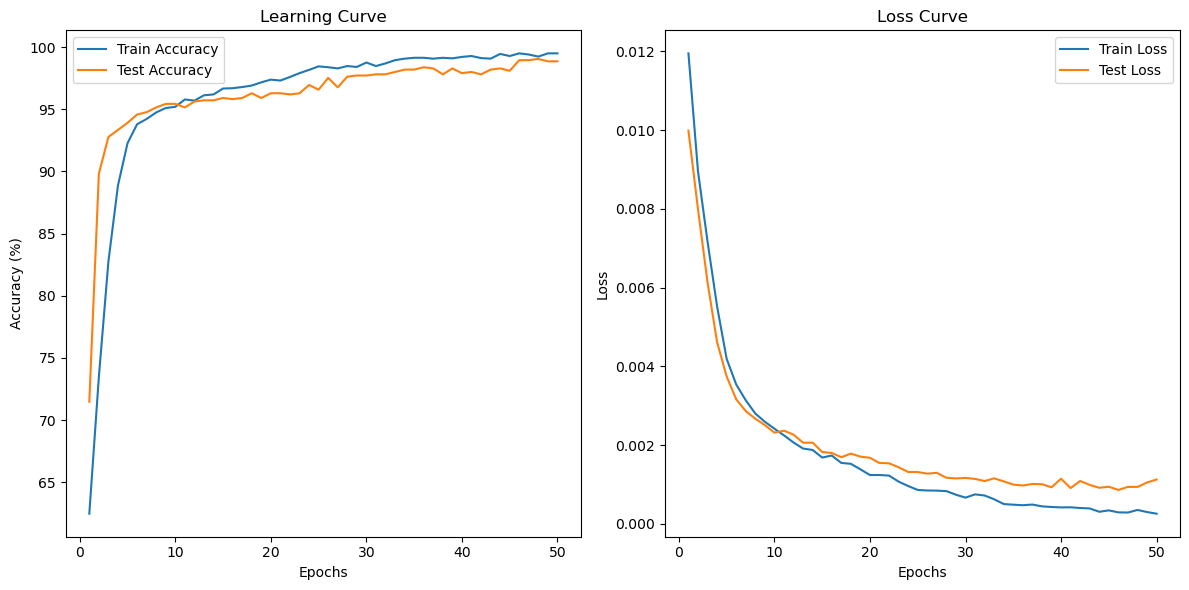

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import random
import shap

# --- Set Random Seed for Reproducibility ---
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Simple CNN Model ---
class CNN_Model(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters=64):
        super(CNN_Model, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(cnn_filters*2 * (input_dim // 2), 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Add channel dimension (batch_size, 1, features)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

# --- Initialize Model ---
input_dim = X_train.size(1)  # Number of features after PCA
num_classes = len(label_encoder.classes_)

model = CNN_Model(input_dim=input_dim, num_classes=num_classes).to(device)

# --- Loss and Optimizers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Save History ---
history = {
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': []
}

# --- Training the Model ---
num_epochs = 50
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]

            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies in history
    history['train_losses'].append(epoch_loss)
    history['test_losses'].append(test_loss)
    history['train_accuracies'].append(epoch_accuracy)
    history['test_accuracies'].append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Save the Model and History ---
# Save the model weights
torch.save(model.state_dict(), "cnn_model.pth")

# Save the training history (losses and accuracies)
history_df = pd.DataFrame(history)
history_df.to_csv("model_history.csv", index=False)

# --- Plotting Learning Curves and Loss Curves ---
# Learning curve (Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history['train_accuracies']) + 1), history['train_accuracies'], label='Train Accuracy')
plt.plot(range(1, len(history['test_accuracies']) + 1), history['test_accuracies'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curve')
plt.legend()

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history['train_losses']) + 1), history['train_losses'], label='Train Loss')
plt.plot(range(1, len(history['test_losses']) + 1), history['test_losses'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()




### Model Explainability with LIME  
we use LIME to interpret CNN predictions by identifying the most influential gene features, visualizing the top 10, and saving the top important genes for further biological analysis.


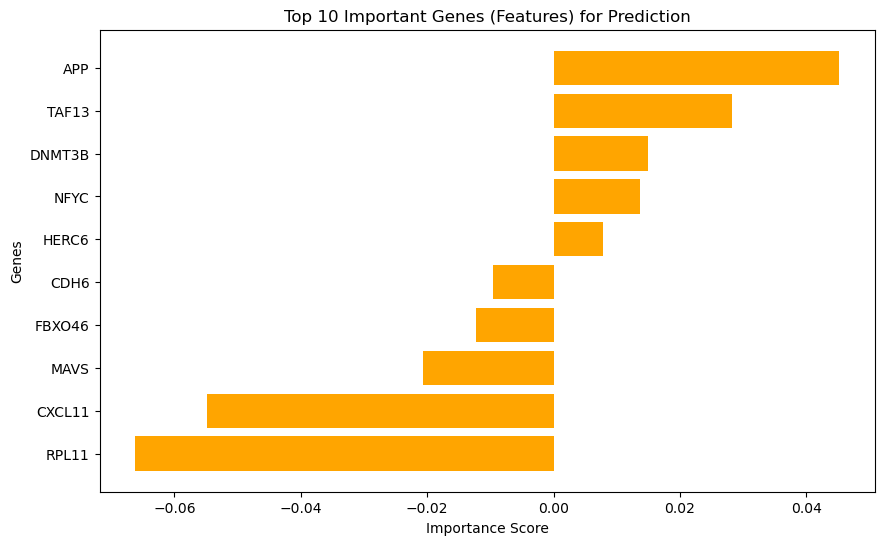

In [15]:
import lime
import lime.lime_tabular
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Function to convert your model's output to probabilities for LIME
def model_predict(input_data):
    # Convert input data (which is a NumPy array) into a PyTorch tensor
    input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Perform a forward pass through the CNN model (output is raw logits)
    with torch.no_grad():
        outputs = model(input_tensor)
    
    # Apply softmax to get probabilities for each class
    return torch.softmax(outputs, dim=1).cpu().detach().numpy()  # Return as numpy array

# Convert PyTorch tensors to NumPy arrays for LIME
X_train_np = X_train.cpu().numpy()  # Ensure X_train is on CPU and converted to numpy array
X_test_np = X_test.cpu().numpy()    # Ensure X_test is on CPU and converted to numpy array
y_train_np = y_train.cpu().numpy()  # Ensure y_train is on CPU and converted to numpy array

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,  # Your training data as a numpy array
    training_labels=y_train_np,  # Your target labels as a numpy array
    mode="classification",  # For classification tasks
    class_names=label_encoder.classes_,  # Class names from label encoder
    discretize_continuous=True  # Discretize continuous features if needed
)

# --- Choose a sample to explain ---
sample_index = 0  # Choose a test sample (change the index to select a different one)
sample = X_test_np[sample_index]  # Sample to explain (as numpy array)

# Explain the model's prediction for this particular sample
explanation = explainer.explain_instance(sample, model_predict)

# Get feature names (the gene names) from your dataset
feature_names = df.drop(columns=['Sample_ID', 'Condition']).columns.tolist()

# Get the feature importances from the explanation object
importance_scores = explanation.as_list()

# Convert the feature names and importance scores into a DataFrame
importance_df = pd.DataFrame(importance_scores, columns=["Feature", "Importance"])

# Function to clean the feature names and exclude non-valid features like 'FALSE'
def clean_feature_name(feature):
    # Check if feature is a valid feature (not 'FALSE' or non-numeric value)
    try:
        feature_number = float(feature.split()[0])  # Cleanly parse the numeric part
        return int(feature_number)  # Return the integer index of the feature
    except ValueError:
        return None  # If the feature cannot be converted to a valid number, return None

# Apply the cleaning function to the 'Feature' column
importance_df["Cleaned_Feature"] = importance_df["Feature"].apply(clean_feature_name)

# Drop rows with 'None' values in the Cleaned_Feature column
importance_df = importance_df.dropna(subset=["Cleaned_Feature"])

# Map the cleaned feature numbers to the actual gene names
importance_df["Gene"] = importance_df["Cleaned_Feature"].apply(
    lambda x: feature_names[x - 1]  # Adjusting for 0-based indexing
)

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# --- Visualize Top 20 Genes --- 
top_20_genes = importance_df.head(20)  # Get the top 20 genes based on importance

plt.figure(figsize=(10, 6))
plt.barh(top_20_genes["Gene"], top_20_genes["Importance"], color='orange')
plt.xlabel('Importance Score')
plt.ylabel('Genes')
plt.title('Top 10 Important Genes (Features) for Prediction')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top

# Save the plot as SVG with 300 DPI
plt.savefig("top_10_genes_importance.svg", format='svg', dpi=300)

# Show the plot
plt.show()

# --- Save Top 500 Genes with their Importance Scores to CSV ---
top_500_genes = importance_df.head(500)  # Select the top 500 genes based on importance scores
top_500_genes.to_csv("top_500_genes_importance.csv", index=False)


                Feature  Importance  Cleaned_Feature    Gene
1              6 > 0.77    0.049578                6     APP
3              5 > 0.81    0.041914                5   TAF13
4           65 <= -0.18    0.018124               65    PKN1
5           1481 > 0.02    0.013062             1481    CLK4
6           1710 > 0.01    0.010659             1710   USP36
9          719 <= -0.04   -0.008860              719   RPS10
8  -0.00 < 2969 <= 0.00   -0.010321                0    MAVS
7          625 <= -0.07   -0.010537              625    NT5C
2              3 > 1.95   -0.047377                3  CXCL11
0              2 > 2.83   -0.057479                2   RPL11


### ✅ Final Training Run with Reproducibility and Logging  
This Code performs a full rerun of the CNN training pipeline with fixed random seed for reproducibility, saving the trained model and training history to files for reliable evaluation and record-keeping.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import os
import random

# --- Set Random Seed for Reproducibility ---
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Load your gene expression dataset
df = pd.read_csv('Duplicate_nan_filled_dataset.csv')

# Split the dataset into features (X) and target (y)
X = df.drop(columns=['Sample_ID', 'Condition'])  # Drop Sample_ID and Condition columns
y = df['Condition']

# Encode target labels as numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA to reduce to 3000 features ---
pca = PCA(n_components=3000)  # Preserving top 3000 features
X_pca = pca.fit_transform(X_scaled)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_pca, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_encoded, dtype=torch.long).to(device)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Simple CNN Model ---
class CNN_Model(nn.Module):
    def __init__(self, input_dim, num_classes, cnn_filters=64):
        super(CNN_Model, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=cnn_filters, out_channels=cnn_filters*2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully connected layer for classification
        self.fc1 = nn.Linear(cnn_filters*2 * (input_dim // 2), 128)  # Flattened size after pooling
        self.fc2 = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Add channel dimension (batch_size, 1, input_dim)
        x = x.unsqueeze(1)  # Shape: (batch_size, 1, input_dim)

        # CNN layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output for fully connected layer
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

# --- Initialize Model ---
input_dim = X_train.size(1)  # Number of features after PCA
num_classes = len(label_encoder.classes_)

model = CNN_Model(input_dim=input_dim, num_classes=num_classes).to(device)

# --- Loss and Optimizers ---
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Early Stopping Setup ---
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# --- Save History ---
history = {
    'train_losses': [],
    'test_losses': [],
    'train_accuracies': [],
    'test_accuracies': []
}

# --- Training the Model ---
num_epochs = 50
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(X_train)
    epoch_accuracy = 100 * correct_preds / total_preds

    # Validation (on test set)
    model.eval()
    test_loss = 0.0
    correct_preds_test = 0
    total_preds_test = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs_test = X_test[i:i+batch_size]
            labels_test = y_test[i:i+batch_size]

            outputs_test = model(inputs_test)
            loss_test = criterion(outputs_test, labels_test)
            test_loss += loss_test.item()

            _, predicted_test = torch.max(outputs_test, 1)
            total_preds_test += labels_test.size(0)
            correct_preds_test += (predicted_test == labels_test).sum().item()

    test_loss = test_loss / len(X_test)
    test_accuracy = 100 * correct_preds_test / total_preds_test

    # Store losses and accuracies in history
    history['train_losses'].append(epoch_loss)
    history['test_losses'].append(test_loss)
    history['train_accuracies'].append(epoch_accuracy)
    history['test_accuracies'].append(test_accuracy)

    # Print the progress
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f} Train Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} Test Accuracy: {test_accuracy:.2f}%")

    # Early stopping
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# --- Save the Model and History ---
# Save the model weights
torch.save(model.state_dict(), "cnn_model.pth")

# Save the training history (losses and accuracies)
history_df = pd.DataFrame(history)
history_df.to_csv("model_history.csv", index=False)


🚀 Using device: cuda
Epoch [1/50] Train Loss: 0.0119 Train Accuracy: 62.48% | Test Loss: 0.0100 Test Accuracy: 71.48%
Epoch [2/50] Train Loss: 0.0090 Train Accuracy: 73.48% | Test Loss: 0.0080 Test Accuracy: 89.83%
Epoch [3/50] Train Loss: 0.0072 Train Accuracy: 82.77% | Test Loss: 0.0061 Test Accuracy: 92.78%
Epoch [4/50] Train Loss: 0.0055 Train Accuracy: 88.88% | Test Loss: 0.0046 Test Accuracy: 93.35%
Epoch [5/50] Train Loss: 0.0042 Train Accuracy: 92.28% | Test Loss: 0.0037 Test Accuracy: 93.92%
Epoch [6/50] Train Loss: 0.0035 Train Accuracy: 93.80% | Test Loss: 0.0032 Test Accuracy: 94.58%
Epoch [7/50] Train Loss: 0.0031 Train Accuracy: 94.23% | Test Loss: 0.0029 Test Accuracy: 94.77%
Epoch [8/50] Train Loss: 0.0028 Train Accuracy: 94.75% | Test Loss: 0.0027 Test Accuracy: 95.15%
Epoch [9/50] Train Loss: 0.0026 Train Accuracy: 95.10% | Test Loss: 0.0025 Test Accuracy: 95.44%
Epoch [10/50] Train Loss: 0.0024 Train Accuracy: 95.20% | Test Loss: 0.0023 Test Accuracy: 95.44%
Epoch [1

c:\Users\Shafiya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1561: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


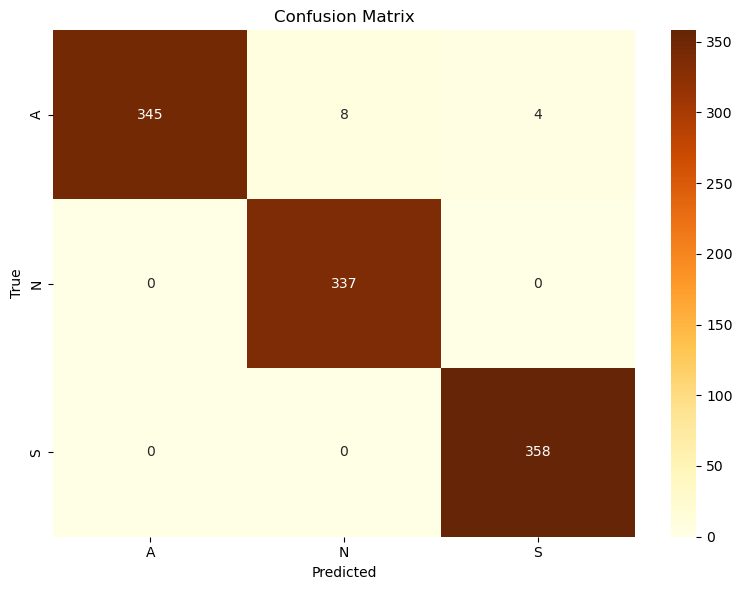

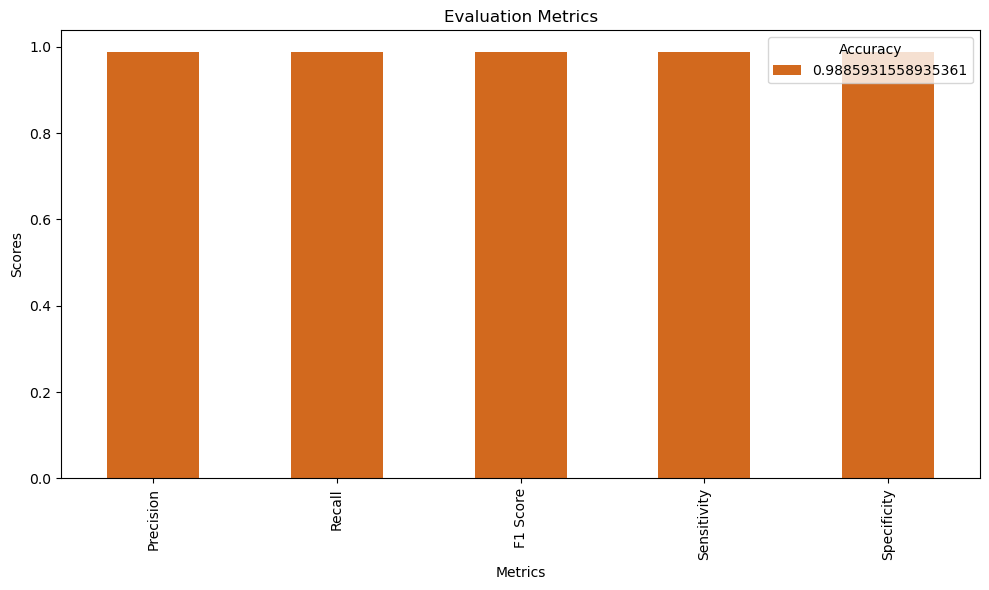

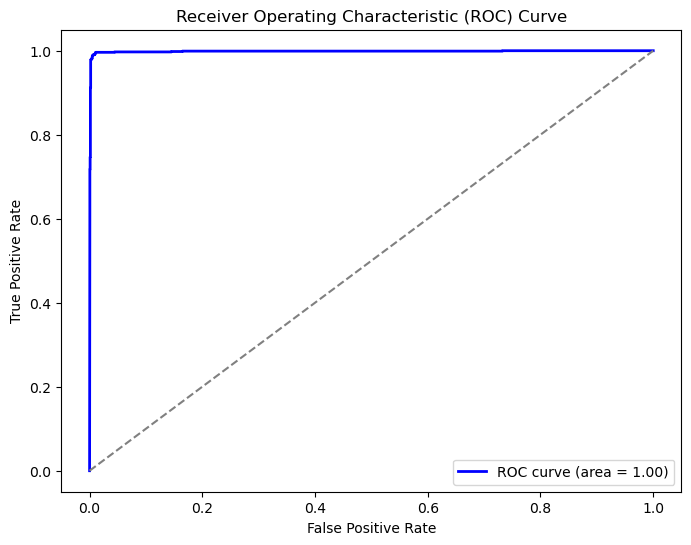

In [25]:
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

# Create a directory for saving results
result_dir = "model_results"
os.makedirs(result_dir, exist_ok=True)

# Predict on test set
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs, 1)

# Compute confusion matrix
cm = confusion_matrix(y_test.cpu(), predicted.cpu())
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Compute precision, recall, f1-score
precision = precision_score(y_test.cpu(), predicted.cpu(), average='weighted')
recall = recall_score(y_test.cpu(), predicted.cpu(), average='weighted')
f1 = f1_score(y_test.cpu(), predicted.cpu(), average='weighted')
accuracy = accuracy_score(y_test.cpu(), predicted.cpu())

# Compute sensitivity and specificity
sensitivity = recall_score(y_test.cpu(), predicted.cpu(), pos_label=1, average='weighted')  # for class 1
specificity = recall_score(y_test.cpu(), predicted.cpu(), pos_label=0, average='weighted')  # for class 0

# Save confusion matrix with the 'YlOrBr' color map (Yellow-Orange-Brown)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlOrBr', cbar=True)  # YlOrBr color map
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
confusion_matrix_path = os.path.join(result_dir, "confusion_matrix_YlOrBr.svg")
plt.savefig(confusion_matrix_path, format='svg', dpi=300)  # Save as SVG with 300 DPI
plt.show()

# Save evaluation metrics to CSV
eval_metrics = {
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1 Score": [f1],
    "Sensitivity": [sensitivity],
    "Specificity": [specificity]
}

eval_df = pd.DataFrame(eval_metrics)
eval_csv_path = os.path.join(result_dir, "evaluation_metrics.csv")
eval_df.to_csv(eval_csv_path, index=False)

# Bar plot for evaluation metrics with 'chocolate' color
plt.figure(figsize=(10, 6))
eval_df.set_index('Accuracy').T.plot(kind='bar', color='chocolate', ax=plt.gca())  # Chocolate color
plt.title('Evaluation Metrics')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.tight_layout()
eval_barplot_path = os.path.join(result_dir, "evaluation_metrics_barplot_chocolate.svg")
plt.savefig(eval_barplot_path, format='svg', dpi=300)  # Save as SVG with 300 DPI
plt.show()

# Compute and save AUC-ROC curve (multi-class handling)
y_test_bin = label_binarize(y_test.cpu(), classes=np.arange(num_classes))
predictions_prob = torch.softmax(model(X_test), dim=1).cpu().detach().numpy()

# Calculate AUC for each class
roc_auc = roc_auc_score(y_test_bin, predictions_prob, average='macro', multi_class='ovr')

# Compute ROC curve for each class
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), predictions_prob.ravel())

# Plot the ROC curve with dots at fluctuation points
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Mark fluctuation points (e.g., points at fpr=0.05, 0.1, 0.5)
for point in [0.05, 0.1, 0.5]:
    if point in fpr:
        index = list(fpr).index(point)
        plt.scatter(fpr[index], tpr[index], color='red', marker='o', label=f'Fluctuation Point (FPR={point})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save AUC curve with fluctuation points
roc_curve_path = os.path.join(result_dir, "roc_curve_with_fluctuations.svg")
plt.savefig(roc_curve_path, format='svg', dpi=300)
plt.show()
